# SHAMap InnerNode Compress Params

The existing rippled SHAMap implementation always contains space to store 16 children. This requires space for a hash (32 bytes/child) and a shared pointer (16 bytes/child). Data collected from a running rippled server shows that most inner nodes have far fewer that 16 children. Using this observation, we implemented a SHAMapInnerNode that supports storing hashes and children in compressed arrays. There are two main parameters that need to be set:

1. How many sparse array sizes should be supported? For example, should we use a sparse array when there are 4 or fewer children and a dense array when there are more than 4 (one sparse array size)? Or should there be sparse array sizes for 4 or fewer and 8 or fewer children (2 sparse array sizes). Of course, the greatest savings will be when there is a specialized array for each potential size, but fewer sparse array sizes have other benefits (not addressed in this notebook).

2. Where should the boundaries be between the different sparse array representations? For example, should we use a sparse array if there are 8 or fewer children? Is that better than if we chose 4 or fewer children?



In [1]:
import itertools
import numpy
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def plot_it(d):
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(d)

# Collected Data
This data was collected from my dogfood machine. The index is the number of children, and the value is the number of inner nodes with that many children.

In [2]:
collected_child_histogram = [
  1,
  100420,
  550490,
  280953,
  195927,
  108574,
  45531,
  15052,
  4035,
  897,
  189,
  207,
  189,
  1256,
  6383,
  23127,
  48588
]


The data above shows that most inner nodes only have a handful of children. A plot makes this easier to see.

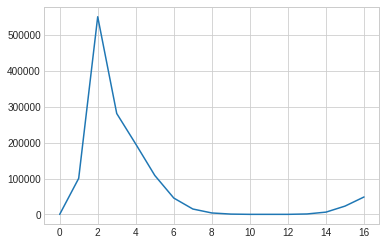

In [3]:
plot_it(collected_child_histogram)

The `savings` function below computes the ratio of the dense size if sparse arrays were used at the given indexes. For example, `savings(child_hist, [4,8])` would compute based on a sparse array for 4 or fewer childen, another sparse array for between 5 and 8 children, and a dense array for 9 to 16 children.

In [4]:
def savings(child_hist, arg_indexes):
    if not arg_indexes:
        return 1.0
    indexes = [a+1 for a in arg_indexes] # add one (and copy so we don't modify origional list)
    if indexes[0] != 0:
        indexes.insert(0, 0)
    if indexes[-1] != 17:
        indexes.append(17)
    per_child_bytes = 48.0 # 32 for the hash 16 for the shared_ptr
    dense_bytes = 16.0*per_child_bytes*sum(child_hist)
    sparse_bytes = 0.0
    for i in range(1, len(indexes)):
        sparse_bytes += (indexes[i]-1)*per_child_bytes*sum(child_hist[indexes[i-1]:indexes[i]])
    return (sparse_bytes/dense_bytes)



Using that function, let's compute the raio if we used a single sparse array, and set the boundary at every possible value

In [5]:


s = [savings(collected_child_histogram, [i]) for i in range(17)]
s



[0.999999276316218,
 0.9318690164920297,
 0.5878279825360629,
 0.45207042311619683,
 0.3878769578360118,
 0.3848681068215157,
 0.42019540909482356,
 0.4720486185238443,
 0.5292498511020618,
 0.587809619060094,
 0.646642668106315,
 0.7054887434606124,
 0.7643568007097891,
 0.8230971730016738,
 0.8814873728035293,
 0.9396976467250776,
 1.0]

The data shows that the best boundary value is a sparse array for 5 or fewer values. Note that while this notebook focuses on space savings, computation overhead is also a consideration, so there may be reasons to choose other values. For example, a value of 4 gives almost as good of savings and 4 hashes fit on 2 cache lines, while 5 hashes do not.

Here's a plot of the above data:

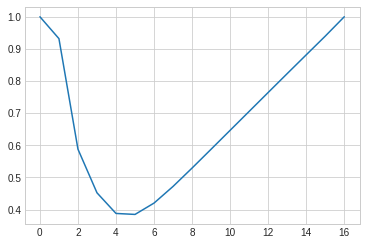

In [6]:
plot_it(s)

The code below finds the best boundary values given the number of allowed boundaries (the `dim` parameter). The more boundaries, the better the savings. However, other implementation considerations makes us want to keep the `dim` parameter
small.

In [7]:
def savings_dim(dim=1):
    if dim == 0:
        s = savings(collected_child_histogram, [])
        return ([s], [()], 0)
    args = [arg for arg in itertools.combinations(range(17),dim)]
    r = [savings(collected_child_histogram, arg) for arg in args]
    return (r, args, numpy.argmin(r))


def doit():
    result = []
    for dim in range(17):
        r, args, arg_min = savings_dim(dim)
        result.append([r[arg_min], args[arg_min]])
    return result

by_dim = doit()
by_dim

[[1.0, ()],
 [0.3848681068215157, (5,)],
 [0.2937501221216382, (3, 6)],
 [0.25929318528692974, (2, 4, 6)],
 [0.24646873975535147, (2, 3, 5, 7)],
 [0.23760691523274757, (2, 3, 4, 5, 7)],
 [0.23306484966554955, (1, 2, 3, 4, 5, 7)],
 [0.23022624526077584, (1, 2, 3, 4, 5, 6, 8)],
 [0.2287676605980957, (1, 2, 3, 4, 5, 6, 8, 15)],
 [0.228025929951752, (1, 2, 3, 4, 5, 6, 7, 9, 15)],
 [0.2276539564877889, (1, 2, 3, 4, 5, 6, 7, 9, 14, 15)],
 [0.2274714524840084, (1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 15)],
 [0.22738818361883864, (1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 14, 15)],
 [0.2273523612716282, (1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15)],
 [0.22734381275695298, (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15)],
 [0.22733526424227776, (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)],
 [0.22733521901204137, (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)]]

It's clear that one boundary gives substantial savings (or 60%). Two boundaries gives an additional ~10% savings, three and additional ~5%. After that there isn't much savings to be had.

The plot below makes this clear:

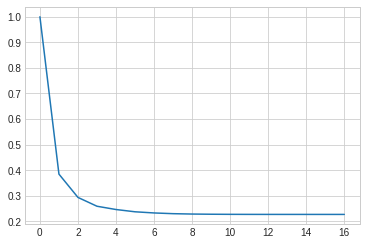

In [8]:
plot_it([x[0] for x in by_dim])

Given the data above, it's probably worth it to support multiple boundaries. Most likely we'll code up 3 boundaries and use `[2,4,6]` as the boundary values.